In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# x is how much hours which are used to train model, and from x to x+7*24 hours will be forecasted
x = 29880    # x = 29976 (style changing period) or 30000-5*24 = 29880 (peaks water demand period)

In [3]:
df = pd.read_csv('E:\sciebo\Data\pre_processed_Raw_data_demand_KK_freq_60.csv')
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], infer_datetime_format=True) 
df.iloc[:,0] = df.iloc[:,0].dt.tz_localize(None) 
df.rename(columns = {'datetime_utc':'ds', 'adjusted':'y'}, inplace = True)
df

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
30384,2021-07-04 08:00:00,86.438042
30385,2021-07-04 09:00:00,92.873500
30386,2021-07-04 10:00:00,96.202250
30387,2021-07-04 11:00:00,105.203000


In [4]:
df_t = df.loc[0:x]
df_t

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
29876,2021-06-13 04:00:00,25.803335
29877,2021-06-13 05:00:00,32.904266
29878,2021-06-13 06:00:00,50.624876
29879,2021-06-13 07:00:00,80.502306


In [5]:
df_f=df.loc[0:x+268]
df_f

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
30144,2021-06-24 08:00:00,98.855625
30145,2021-06-24 09:00:00,96.984295
30146,2021-06-24 10:00:00,104.043444
30147,2021-06-24 11:00:00,95.220694


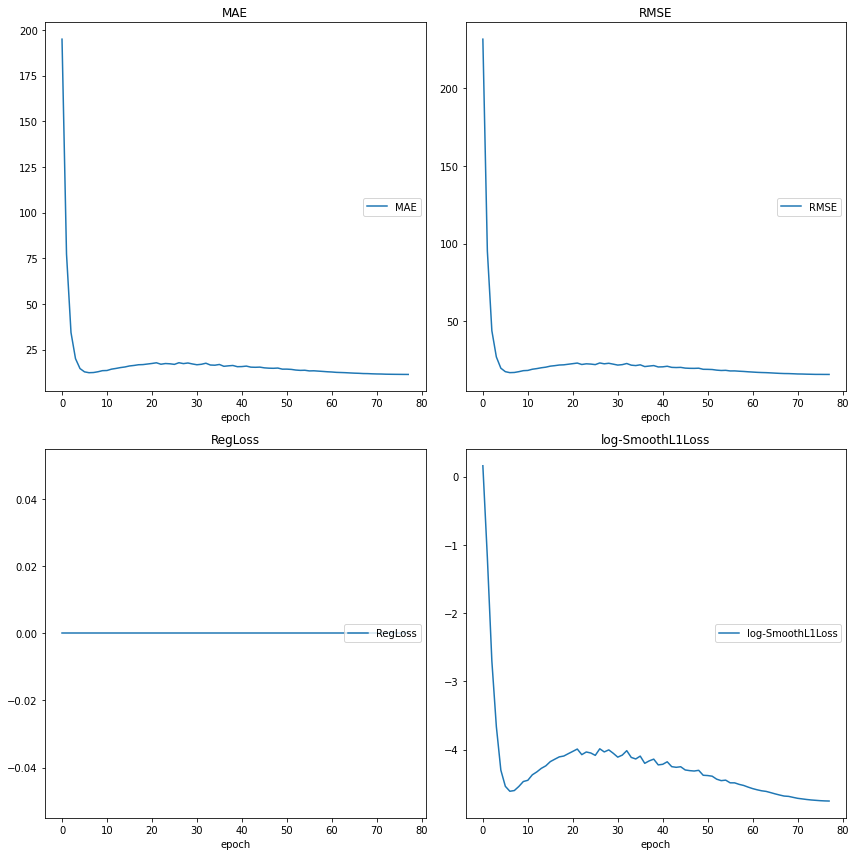

MAE
	MAE              	 (min:   11.394, max:  194.935, cur:   11.394)
RMSE
	RMSE             	 (min:   15.666, max:  231.717, cur:   15.666)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.754, max:    0.157, cur:   -4.754)


In [6]:
m = NeuralProphet()
metrics_try = m.fit(df_t, progress="plot-all")

In [7]:
df_t = df.loc[0:x]
future = m.make_future_dataframe(
                                    df_t, periods=336,n_historic_predictions=True
                                 )
future = future.loc[0:x+168]
future

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)



,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
30044,2021-06-20 04:00:00,NaN
30045,2021-06-20 05:00:00,NaN
30046,2021-06-20 06:00:00,NaN
30047,2021-06-20 07:00:00,NaN


In [8]:
file1 = 'E:\sciebo\Data\pre_processed_weather_Barrien_H.csv'                    #
weather = pd.read_csv(file1,parse_dates = True)                                #
rainfall = weather.loc[:,['ID_691_stuendliche_Niederschlagshoehe mm_MA24']]     #
rainfall.columns = ['rainfall']                                                 #
rainfall = rainfall.mask(rainfall>0,1)                                          # devide the rainfall into 0(no) and1 (rain)
sun = weather.loc[:,['ID_691_stuendliche Sonnenscheindauer min']]               #
sun.columns = ['sun']                                                           #
humidity = weather.loc[:,['ID_691_relative Feuchte %_MA24']]                    #
humidity.columns = ['humidity']                                                 #
temperature = weather.loc[:,['ID_691_Lufttemperatur in 2m Hoehe °C_MA24']]     #
temperature.columns = ['temperature']                                           #
weather = pd.concat([rainfall,sun,temperature,humidity],axis=1)                 #
####################################################################################################################
######                                           add sun_duration                                              #####
####################################################################################################################
lastvalue = 0                                                                 
n = 0
newcum = [] 
for _,row in weather.iterrows():
    thisvalue =  row.sun + lastvalue
    if thisvalue == lastvalue:
            thisvalue = 0
            n = 0
    newcum.append( thisvalue )
    lastvalue = thisvalue
weather['sun_duration'] = newcum
weather["sun_duration"][weather.sun_duration<600]= 600
####################################################################################################################
####                                             add dry_duration                                              #####
####################################################################################################################
lastvalue = 0
s = 0
newcum = [] 
for _,row in weather.iterrows():
    thisvalue =  row.rainfall
    if thisvalue == 0:
        s = s + 1
    elif thisvalue > 0:  
        s = 0
    newcum.append( s )
weather['dry_duration'] = newcum
weather["dry_duration"][weather.dry_duration>300]= 300
####################################################################################################################
####                            weathert is the weatherdata for training model                                 #####
####                            weatherf is the weatherdata for making forecast                                #####
####################################################################################################################
weathert=weather.loc[0:x]
weatherf=weather.loc[0:x+336]
#####################################################################################################################
####                              data_train is the data frame for training model                            ########
#####################################################################################################################
data_train = pd.concat([df_t,weathert],axis=1)
data_train 

WARNING - (py.warnings._showwarnmsg) - C:\Windows\Temp\ipykernel_2692\1720654827.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["dry_duration"][weather.dry_duration>300]= 300



,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,0.0,0.0,1.5,80.0,600.0,1
1,2018-01-15 09:00:00,59.226733,0.0,0.0,1.8,80.0,600.0,2
2,2018-01-15 10:00:00,84.631849,0.0,0.0,2.3,79.3,600.0,3
3,2018-01-15 11:00:00,107.245748,0.0,0.0,2.7,78.8,600.0,4
4,2018-01-15 12:00:00,96.690556,0.0,0.0,3.1,78.4,600.0,5
...,...,...,...,...,...,...,...,...
29876,2021-06-13 04:00:00,25.803335,0.0,56.0,14.9,72.0,600.0,164
29877,2021-06-13 05:00:00,32.904266,0.0,57.0,14.7,71.5,600.0,165
29878,2021-06-13 06:00:00,50.624876,0.0,60.0,14.6,70.8,600.0,166
29879,2021-06-13 07:00:00,80.502306,0.0,60.0,14.4,70.0,600.0,167


In [9]:
######################################################################################################################################
####                                          devide the data into day and night                                                   ###
####          In this way, the weather data at night is marked, and then we can make it less effective during night                ###   
######################################################################################################################################
def is_DAY_season(ds):                                                          
    date = pd.to_datetime(ds)                                                   
    return(date.hour> 5.30 and date.hour<22.30)                                       
data_train['sleep'] = ~data_train['ds'].apply(is_DAY_season)                    
data_train.sleep = data_train.sleep.replace({True: 1, False: 0})               
data_train

,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration,sleep
0,2018-01-15 08:00:00,59.759240,0.0,0.0,1.5,80.0,600.0,1,0
1,2018-01-15 09:00:00,59.226733,0.0,0.0,1.8,80.0,600.0,2,0
2,2018-01-15 10:00:00,84.631849,0.0,0.0,2.3,79.3,600.0,3,0
3,2018-01-15 11:00:00,107.245748,0.0,0.0,2.7,78.8,600.0,4,0
4,2018-01-15 12:00:00,96.690556,0.0,0.0,3.1,78.4,600.0,5,0
...,...,...,...,...,...,...,...,...,...
29876,2021-06-13 04:00:00,25.803335,0.0,56.0,14.9,72.0,600.0,164,1
29877,2021-06-13 05:00:00,32.904266,0.0,57.0,14.7,71.5,600.0,165,1
29878,2021-06-13 06:00:00,50.624876,0.0,60.0,14.6,70.8,600.0,166,0
29879,2021-06-13 07:00:00,80.502306,0.0,60.0,14.4,70.0,600.0,167,0


In [10]:
data_train["humidity"] = data_train["humidity"].mask(data_train.sleep == 1,80)
data_train["temperature"] = data_train["temperature"].mask(data_train.sleep == 1,12)

In [11]:
###########################################       devide the data into seasons       ##########################################
######        In this way, the weather data in different seasons is marked,                                              ######
######        and then we can make the weather parameters different effective during different seasons                   ######   
###############################################################################################################################
data_train['ds'] = pd.to_datetime(data_train['ds'])                                      #, format= '%d-%b-%y')
def get_season(row):
    if row['ds'].month >= 3 and row['ds'].month <= 5:
        return 'spring'
    elif row['ds'].month >= 6 and row['ds'].month <= 8:
        return 'summer'
    elif row['ds'].month >= 9 and row['ds'].month <= 11:
        return 'autumn'
    else:
        return 'winter'
data_train['Season'] = data_train.apply(get_season, axis=1)

###############################################################################################################################
####                       make the weather parameters effect differently during different seasons                         ####
###############################################################################################################################
###############################################################################################################################
####                                                                                                                       #### 

my_cond= (data_train['Season'] == 'summer')
replace=0
data_train['dry_duration'].mask(~my_cond,replace,inplace=True)
###############################################################################################################################
####                                       make the dry_duration only effective during summer                              ####
###############################################################################################################################


my_cond= (data_train['Season'] == 'spring') &  (data_train['temperature'] <5) 
replace=5
data_train['temperature'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                      add threshold of temperature during spring with 5                                ####
###############################################################################################################################


my_cond= (data_train['Season'] != 'spring') &  (data_train['temperature'] <12) 
replace=12
data_train['temperature'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                add threshold of temperature during other seasons with 12                              ####
###############################################################################################################################


my_cond= (data_train['Season'] == 'winter')
replace=90
data_train['humidity'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                      make the humidity less effective during winter                                   ####
###############################################################################################################################


my_cond= (data_train['Season'] == 'autumn') 
replace=80
data_train['humidity'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                      make the humidity less effective during autumn                                   ####
###############################################################################################################################


my_cond= (data_train['Season'] == 'winter')
replace=600
data_train['sun_duration'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                      make the sun_duration less effective during winter                               ####
###############################################################################################################################
data_train = data_train.drop(['sleep','Season'],axis=1)
data_train

,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,0.0,0.0,12.0,90.0,600.0,0
1,2018-01-15 09:00:00,59.226733,0.0,0.0,12.0,90.0,600.0,0
2,2018-01-15 10:00:00,84.631849,0.0,0.0,12.0,90.0,600.0,0
3,2018-01-15 11:00:00,107.245748,0.0,0.0,12.0,90.0,600.0,0
4,2018-01-15 12:00:00,96.690556,0.0,0.0,12.0,90.0,600.0,0
...,...,...,...,...,...,...,...,...
29876,2021-06-13 04:00:00,25.803335,0.0,56.0,12.0,80.0,600.0,164
29877,2021-06-13 05:00:00,32.904266,0.0,57.0,12.0,80.0,600.0,165
29878,2021-06-13 06:00:00,50.624876,0.0,60.0,14.6,70.8,600.0,166
29879,2021-06-13 07:00:00,80.502306,0.0,60.0,14.4,70.0,600.0,167


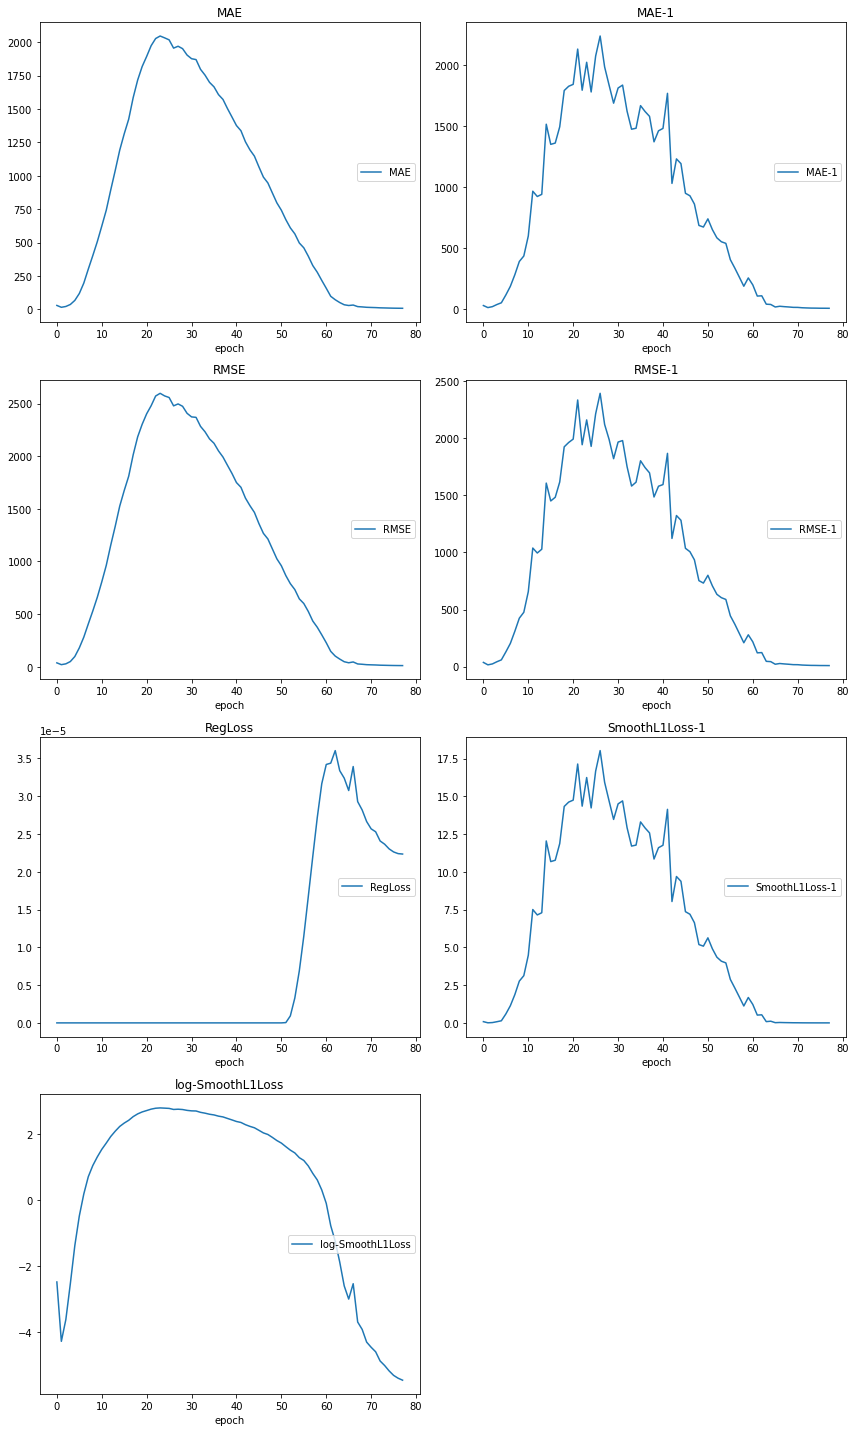

MAE
	MAE              	 (min:    7.758, max: 2045.751, cur:    7.758)
MAE-1
	MAE-1            	 (min:    6.003, max: 2241.177, cur:    6.003)
RMSE
	RMSE             	 (min:   11.154, max: 2597.292, cur:   11.154)
RMSE-1
	RMSE-1           	 (min:    8.130, max: 2396.164, cur:    8.130)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
SmoothL1Loss-1
	SmoothL1Loss-1   	 (min:    0.002, max:   18.031, cur:    0.002)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -5.458, max:    2.798, cur:   -5.458)


In [12]:
 #data_train_T, data_text_T = NeuralProphet().split_df(data_train, valid_p=0.0002)

#  the forecast process consiider too much past values of y or yhat .
#  By setting an ar_reg > 0 we can reduce the number of non-zero AR coefficients.
#  I choose ar_reg=0.1 to make pass value make less effect. (still don't know if it works)
#  I need to give weather parameters different weights but it seems the model finished it itself.
#  I can adjust the hyperparameters if it is needed.
m = NeuralProphet( 
                 n_forecasts=24*7,
                 n_lags=24*14, 
                 d_hidden = 2,
                 ar_reg=0.01,
                 #ar_sparsity=0.1,
                 #batch_size = 365*24,
                 learning_rate=1,
#                changepoint_prior_scale = 0.003,
#                seasonality_prior_scale = 0.01,
                 changepoints_range=0.95,
                 n_changepoints=3,
                 daily_seasonality=7 ,yearly_seasonality = 6,weekly_seasonality = 2
#                mcmc_samples=100
                 )
m = m.highlight_nth_step_ahead_of_each_forecast(1)
m.add_future_regressor('rainfall',mode="multiplicative")
m.add_future_regressor('sun',mode="multiplicative")
m.add_future_regressor('temperature',mode="multiplicative")
m.add_future_regressor('humidity',mode="multiplicative")
m.add_country_holidays(country_name="Germany")
m.add_future_regressor('dry_duration',mode="multiplicative")
m.add_future_regressor('sun_duration',mode="multiplicative")
metrics = m.fit(data_train, progress="plot-all")   #_T,validation_df=data_text_T

In [13]:
future['sleep'] = ~future['ds'].apply(is_DAY_season)

future_w = pd.concat([future,weatherf],axis=1)
future_w["humidity"] = future_w["humidity"].mask(future_w.sleep == 1,80)
future_w["temperature"] = future_w["temperature"].mask(future_w.sleep == 1,12)    #if spring, 12 = 5
future_w = future_w.loc[0:x+168]

future_w

,ds,y,sleep,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,False,0.0,0.0,1.5,80.0,600.0,1
1,2018-01-15 09:00:00,59.226733,False,0.0,0.0,1.8,80.0,600.0,2
2,2018-01-15 10:00:00,84.631849,False,0.0,0.0,2.3,79.3,600.0,3
3,2018-01-15 11:00:00,107.245748,False,0.0,0.0,2.7,78.8,600.0,4
4,2018-01-15 12:00:00,96.690556,False,0.0,0.0,3.1,78.4,600.0,5
...,...,...,...,...,...,...,...,...,...
30044,2021-06-20 04:00:00,NaN,True,1.0,0.0,12.0,80.0,600.0,0
30045,2021-06-20 05:00:00,NaN,True,1.0,0.0,12.0,80.0,600.0,0
30046,2021-06-20 06:00:00,NaN,False,1.0,10.0,22.3,71.8,600.0,0
30047,2021-06-20 07:00:00,NaN,False,1.0,1.0,22.2,72.6,600.0,0


In [14]:
###############################################################################################################################
####                       make the weather parameters effect differently during different seasons                         ####
###############################################################################################################################
future_w['ds'] = pd.to_datetime(future_w['ds'])#, format= '%d-%b-%y')
def get_season(row):
    if row['ds'].month >= 3 and row['ds'].month <= 5:
        return 'spring'
    elif row['ds'].month >= 6 and row['ds'].month <= 8:
        return 'summer'
    elif row['ds'].month >= 9 and row['ds'].month <= 11:
        return 'autumn'
    else:
        return 'winter'
future_w['Season'] = future_w.apply(get_season, axis=1)

my_cond= (future_w['Season'] == 'summer')
replace=0
future_w['dry_duration'].mask(~my_cond,replace,inplace=True)

my_cond= (future_w['Season'] == 'spring') &  (future_w['temperature'] <12) 
replace=12
future_w['temperature'].mask(my_cond,replace,inplace=True)

my_cond= (future_w['Season'] != 'spring') &  (future_w['temperature'] <12) 
replace=12
future_w['temperature'].mask(my_cond,replace,inplace=True)

my_cond= (future_w['Season'] == 'winter')# &  (data_train['temperature'] <12) 
replace=90
future_w['humidity'].mask(my_cond,replace,inplace=True)

my_cond= (future_w['Season'] == 'autumn')# &  (data_train['temperature'] <12) 
replace=80
future_w['humidity'].mask(my_cond,replace,inplace=True)

my_cond= (future_w['Season'] == 'winter')# &  (data_train['temperature'] <12) 
replace=600
future_w['sun_duration'].mask(my_cond,replace,inplace=True)

###############################################################################################################################
####                       make the weather parameters effect differently during day and night                             ####
###############################################################################################################################

future_w["humidity"] = future_w["humidity"].mask(future_w.sleep == 1,80)
future_w["temperature"] = future_w["temperature"].mask(future_w.sleep == 1,12)
future_w["rainfall"] = future_w["rainfall"].mask(future_w.sleep == 1,0)
future_w = future_w.drop(['sleep','Season'],axis=1)
future_w

,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,0.0,0.0,12.0,90.0,600.0,0
1,2018-01-15 09:00:00,59.226733,0.0,0.0,12.0,90.0,600.0,0
2,2018-01-15 10:00:00,84.631849,0.0,0.0,12.0,90.0,600.0,0
3,2018-01-15 11:00:00,107.245748,0.0,0.0,12.0,90.0,600.0,0
4,2018-01-15 12:00:00,96.690556,0.0,0.0,12.0,90.0,600.0,0
...,...,...,...,...,...,...,...,...
30044,2021-06-20 04:00:00,NaN,0.0,0.0,12.0,80.0,600.0,0
30045,2021-06-20 05:00:00,NaN,0.0,0.0,12.0,80.0,600.0,0
30046,2021-06-20 06:00:00,NaN,1.0,10.0,22.3,71.8,600.0,0
30047,2021-06-20 07:00:00,NaN,1.0,1.0,22.2,72.6,600.0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2311: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[comp] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2311: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[comp] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecast

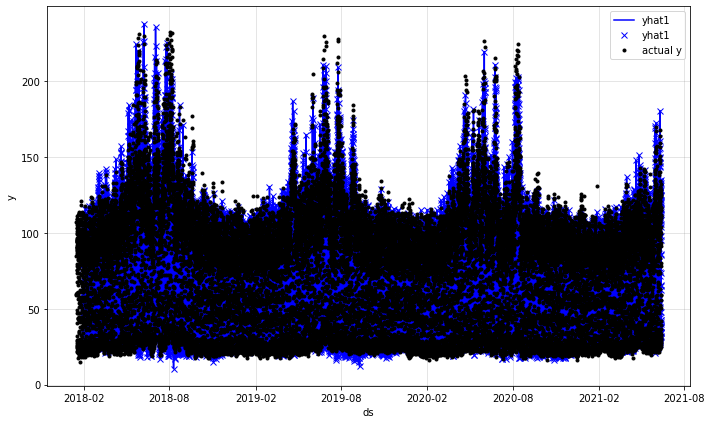

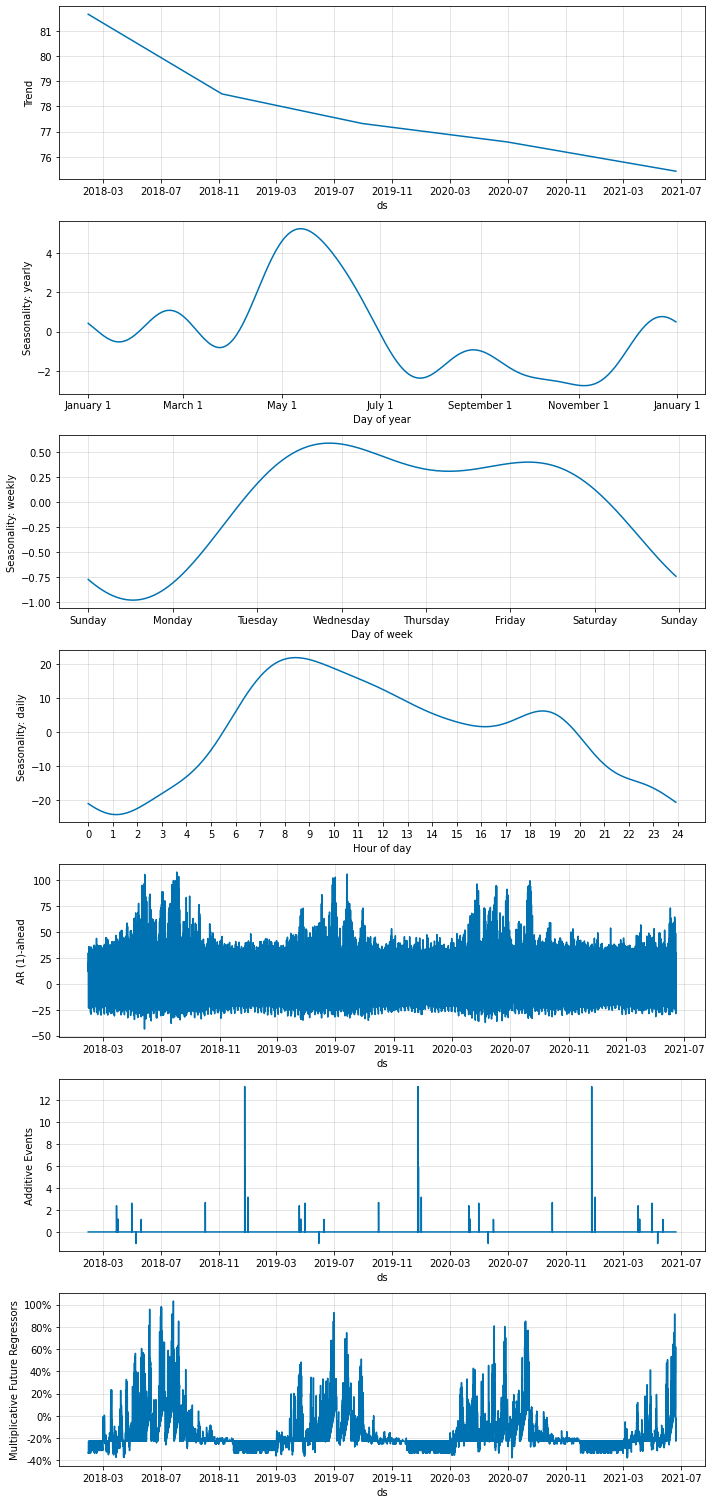

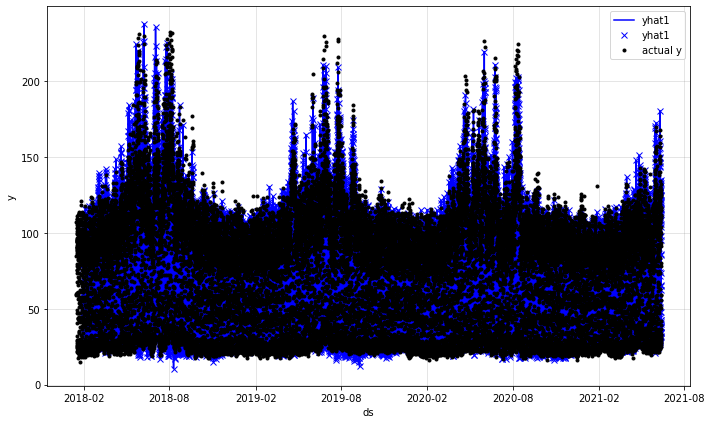

In [15]:
forecast = m.predict(future_w)
fig = m.plot_components(forecast)
m.plot(forecast)  

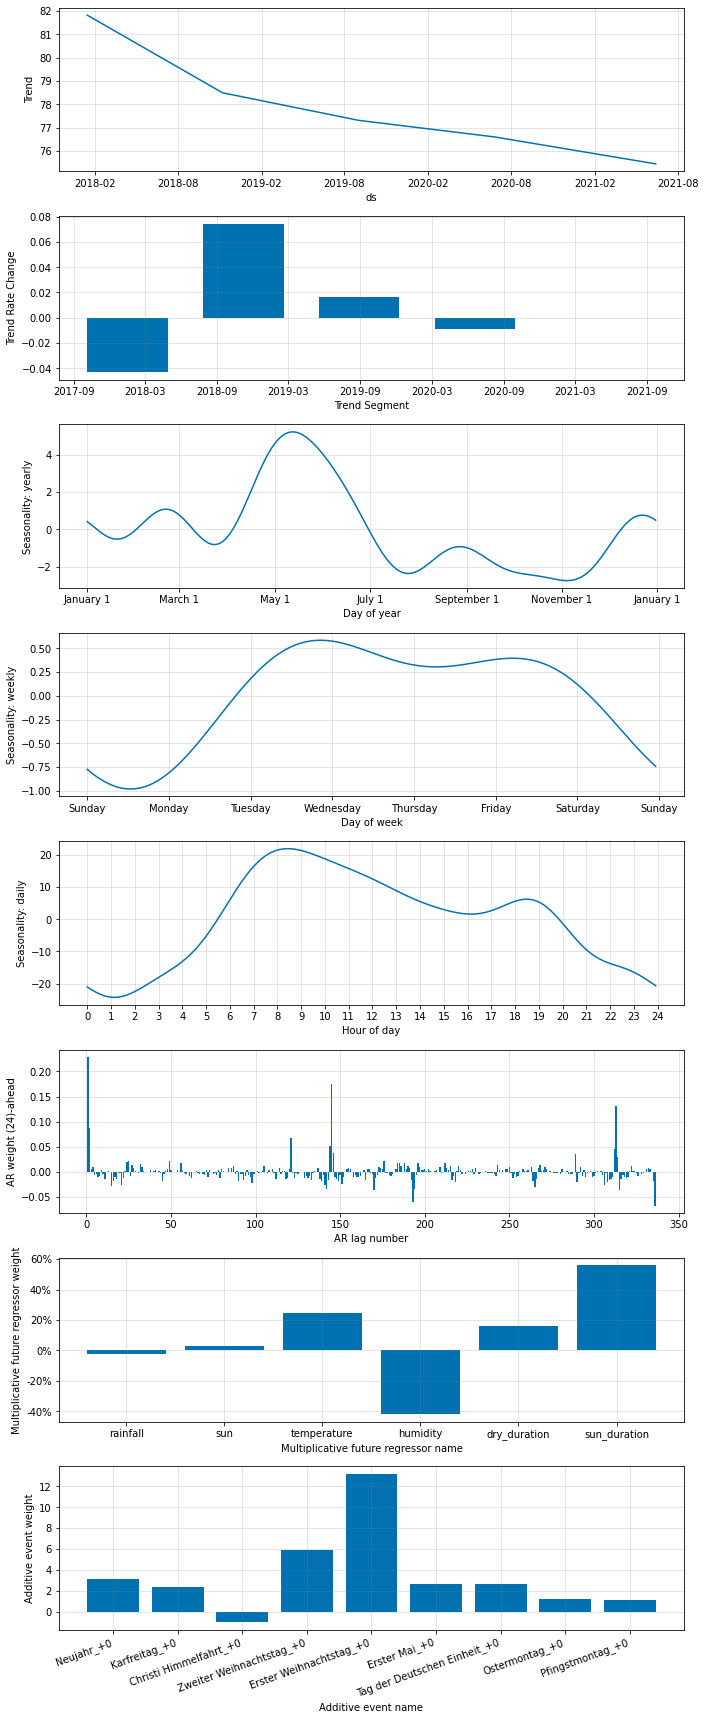

In [16]:
m = m.highlight_nth_step_ahead_of_each_forecast(24)   #we can change (24) to see what happen with ar weight
fig_param = m.plot_parameters()

In [17]:
forecast1 = forecast[x:x+168]
forecast1=forecast1.filter(regex= 'yhat',axis = 1)
def func(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.first_valid_index()]
forecast_text = forecast1.apply(func, axis=1)
forecast_text = pd.DataFrame ( forecast_text, columns = ['y_hat_first']) 
forecast_text

,y_hat_first
29880,108.889275
29881,133.236267
29882,134.298019
29883,129.707123
29884,123.748245
...,...
30043,25.811176
30044,25.772003
30045,32.754097
30046,63.552387


In [18]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
df_3 = df_f.loc[x - 5*24 :x +240]
data_forecast3 = future_w.loc[x - 5*24 :x +240]
forecast_3 = forecast.loc[x:x+240]
trace1 = go.Scatter(
                    x = df_3.ds,                          
                    y = df_3.y,                    
                    mode = "lines+markers",                
                    name = "real waterdemand",             
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),   
                    )
trace2 = go.Scatter(
                    x = forecast_3.ds,
                    y = forecast_text.y_hat_first,
                    mode = "lines+markers",               
                    name = "forecast waterdemand first step",
                    marker = dict(color = 'rgba(80, 26, 80, 0.8)'),    
                    )
trace3 = go.Scatter(
                    x = data_forecast3 .ds,
                    y = data_forecast3 .sun_duration/10-50,
                    mode = "lines+markers",               
                    name = "sun_duration",
                    marker = dict(color = 'rgba(180, 26, 80, 0.8)'),
                    )


data = [trace1, trace2,trace3 ]
layout = dict(
              title = 'Neural prophet forecast with weather parameters style changing days',            
              xaxis= dict(title= 'time',ticklen= 50,zeroline= True)
              ) 
fig = dict(data = data, layout = layout)
iplot(fig)

In [19]:
y_true = df_f.loc[x:x+72,'y']
y_yhat = forecast_text.loc[x:x+72,'y_hat_first']

In [20]:
mean_absolute_error(y_true, y_yhat)   # 3  days

10.213201300734429

In [21]:
mean_squared_error(y_true, y_yhat)    # 3  days

221.73529044220578

In [22]:
y_true = df_f.loc[x:x+7*24-1,'y']
y_yhat = forecast_text.loc[x:x+7*24]

In [23]:
mean_absolute_error(y_true, y_yhat)               #  7  days

12.272234890741256

In [24]:
mean_squared_error(y_true, y_yhat)                 # 7 days

319.1319678222884